# تشخیص تومور مغزی با YOLOv8m و Data Augmentation

##  مرحله 1: نصب پیش‌نیازها

In [ ]:
!pip install ultralytics albumentations tqdm gdown -q
from ultralytics import YOLO
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 21.1 MB/s eta 0:00:00


##  مرحله 2: دانلود و استخراج دیتاست تومور مغزی

In [ ]:
!pip install ultralytics -q
!pip install tqdm -q

import os
import zipfile
from IPython.display import display, Markdown

# دانلود و استخراج دیتاست
dataset_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/brain-tumor.zip"
dataset_dir = "/content/brain-tumor"

if not os.path.exists(dataset_dir):
    os.system(f"wget {dataset_url} -O brain-tumor.zip")
    with zipfile.ZipFile("brain-tumor.zip", 'r') as zip_ref:
        zip_ref.extractall("/content")
    display(Markdown("### دیتاست Brain Tumor با موفقیت دانلود و استخراج شد."))
else:
    display(Markdown("### دیتاست قبلا دانلود و استخراج شده است."))

### دیتاست Brain Tumor با موفقیت دانلود و استخراج شد.

##  مرحله 3: پیش‌پردازش + Data Augmentation

In [ ]:
import albumentations as A

!unzip -q /content/brain_tumor.zip -d /content/brain_tumor

input_path = "/content/brain_tumor/images_augmented"
label_path = "/content/brain_tumor/labels_augmented"

output_path = "brain_tumor/images_augmented"
output_label_path = "brain_tumor/labels_augmented"

os.makedirs(output_path, exist_ok=True)
os.makedirs(output_label_path, exist_ok=True)

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(p=0.3),
    A.Resize(640, 640)
])

for img_file in tqdm(os.listdir(input_path)):
    img_path = os.path.join(input_path, img_file)
    label_file = img_file.replace('.jpg', '.txt')

    if not os.path.exists(os.path.join(label_path, label_file)):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    for i in range(3):
        augmented = transform(image=img)
        aug_img = augmented['image']
        aug_name = img_file.replace('.jpg', f'_aug{i}.jpg')

        cv2.imwrite(os.path.join(output_path, aug_name), aug_img)
        shutil.copy(os.path.join(label_path, label_file),
                    os.path.join(output_label_path, aug_name.replace('.jpg', '.txt')))


unzip:  cannot find or open /content/brain_tumor.zip, /content/brain_tumor.zip.zip or /content/brain_tumor.zip.ZIP.


0it [00:00, ?it/s]


##  مرحله 4: ساخت فایل YAML برای YOLO

In [ ]:
yaml_text = """
path: /content
train: train
val: valid
test: valid
names:
  0: tumor
"""

with open("brain_tumor.yaml", "w") as f:
    f.write(yaml_text)


##  مرحله 5: آموزش YOLOv8m با داده‌های تقویت‌شده

In [ ]:
from ultralytics import YOLO
from IPython.display import display, Markdown

model = YOLO("yolov8n.pt")
display(Markdown("### مدل YOLOv8n پیش‌آموزش‌دیده بارگذاری شد."))

results = model.train(
    data="brain_tumor.yaml",
    epochs=80,
    batch=16,
    imgsz=640,
    project="brain_tumor_finetune",
    name="yolov8_brain_tumor_preprocessed",
    exist_ok=True
    save=True
)

display(Markdown("### آموزش مدل با داده‌های پیش‌پردازش شده کامل شد."))


### مدل YOLOv8n پیش‌آموزش‌دیده بارگذاری شد.

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=brain_tumor.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=80, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_brain_tumor_preprocessed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

train: Scanning /content/train/labels.cache... 878 images, 15 backgrounds, 459 corrupt: 100%|██████████| 893/893 [00:00<?, ?it/s]

train: /content/train/images/00054_145.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00054_164.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_110.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_129.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_147.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_239.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_92.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset cla

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 179.5±100.7 MB/s, size: 3.4 KB)


val: Scanning /content/valid/labels.cache... 223 images, 0 backgrounds, 81 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]

val: /content/valid/images/val_1 (1).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (100).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (102).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (104).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (105).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (106).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (107).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset clas

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to brain_tumor_finetune/yolov8_brain_tumor_preprocessed
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80         0G      1.354      3.116      1.204          2        640: 100%|██████████| 28/28 [00:44<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.20s/it]

                   all        142        154    0.00308      0.851     0.0709     0.0391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/80         0G      1.241       2.15      1.122          6        640: 100%|██████████| 28/28 [00:42<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

                   all        142        154       0.85     0.0737      0.264       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80         0G      1.279      1.876      1.173          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        142        154     0.0878     0.0195     0.0082    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80         0G      1.312      1.718      1.209          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.04s/it]

                   all        142        154      0.574       0.28      0.247      0.151

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/80         0G       1.29      1.654      1.214          1        640: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        142        154      0.715      0.526      0.615      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80         0G      1.312      1.351       1.19          2        640: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

                   all        142        154      0.825      0.695      0.772      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80         0G      1.276      1.282       1.18          2        640: 100%|██████████| 28/28 [00:42<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        142        154      0.799       0.74      0.821      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/80         0G       1.18      1.159      1.154          4        640: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        142        154      0.809      0.773      0.847       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80         0G      1.193      1.102      1.164          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

                   all        142        154      0.689      0.526      0.609       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80         0G      1.208      1.151       1.17          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.00it/s]

                   all        142        154      0.871      0.703      0.821       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/80         0G      1.112     0.9251      1.115          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.832      0.708      0.806      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/80         0G       1.11     0.8608      1.128          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.803      0.792       0.82      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/80         0G      1.096      0.851      1.097          6        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.808       0.74      0.821      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/80         0G      1.137      0.871      1.096          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.823      0.818      0.882      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80         0G      1.097       0.83      1.085          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.862      0.753       0.83      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/80         0G      1.101     0.8319      1.084          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154       0.89      0.851      0.903        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80         0G      1.099     0.8023      1.102          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.852      0.823      0.888      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80         0G      1.077     0.7641      1.117          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        142        154      0.876      0.871       0.93      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80         0G      1.029     0.7608      1.059          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.832      0.802      0.884      0.632

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/80         0G       1.06     0.7638      1.089          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.878      0.857      0.909      0.637

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/80         0G      1.023     0.7411      1.071          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.876      0.827      0.918      0.624

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/80         0G      1.001     0.6936      1.087          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.884      0.793      0.914      0.658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/80         0G     0.9988     0.7242      1.056          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.881      0.714      0.818      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/80         0G       1.03     0.7239      1.075          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.889      0.773      0.895      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/80         0G      1.051     0.6854      1.084          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.845      0.831      0.888      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80         0G     0.9807     0.7093      1.032          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.886      0.805      0.904      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/80         0G      1.029     0.7299      1.057          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.892      0.806      0.922      0.631

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/80         0G     0.9572     0.6666      1.037          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.826      0.805      0.884      0.626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/80         0G     0.9422     0.6299      1.031          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.878      0.838       0.91      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/80         0G     0.9717     0.6213      1.051          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.887      0.792      0.898      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/80         0G     0.9043      0.615      1.022          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.899      0.811       0.93      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80         0G     0.9525     0.6235      1.024          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.868      0.857      0.894       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/80         0G     0.9465      0.627      1.046          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.876      0.857      0.919      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/80         0G     0.9293     0.6107      1.004          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.893      0.799      0.901      0.638

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/80         0G     0.9156     0.5784       1.03          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.892      0.825      0.916      0.666

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/80         0G     0.9563     0.6353      1.041          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.886      0.825      0.879      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/80         0G     0.9484     0.6265      1.039          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.912      0.812      0.923      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/80         0G     0.9573     0.6006      1.046          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.933      0.815      0.923      0.639

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/80         0G     0.9631     0.6159      1.048          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.869      0.799      0.882      0.629

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/80         0G     0.9437     0.5801      1.028          6        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.869      0.864      0.916      0.662

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      41/80         0G     0.9358     0.5953      1.017          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.882      0.823      0.903      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      42/80         0G     0.9041     0.5921      1.014          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.894      0.734      0.874       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/80         0G     0.9014     0.5653      1.036          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.853      0.818      0.884      0.648

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/80         0G     0.8847     0.5509      1.016          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        142        154      0.876      0.828      0.917      0.667

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      45/80         0G     0.8384     0.5211     0.9774          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        142        154      0.888      0.805      0.915      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/80         0G      0.897     0.5421      1.007          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154       0.88      0.864      0.926      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80         0G     0.8621     0.5403     0.9964          8        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.859       0.83      0.928      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/80         0G     0.8785     0.5265      1.008          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.873      0.838      0.925      0.665

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/80         0G      0.851     0.5213      0.972          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.822      0.877      0.919      0.677

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      50/80         0G     0.8329     0.4999     0.9682          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154       0.89       0.87       0.93      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80         0G     0.8358     0.5156     0.9771          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.883      0.838      0.926       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80         0G     0.8392     0.5349      0.993          6        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.869       0.87      0.926      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      53/80         0G     0.8077     0.4978     0.9693          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154       0.94      0.799      0.928      0.672

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      54/80         0G     0.8361     0.5204     0.9757          6        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.865      0.857      0.929       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80         0G     0.8116     0.4925     0.9746          4        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.861      0.896      0.942      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80         0G     0.8379     0.4847      0.975          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.837      0.883       0.92      0.678

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      57/80         0G     0.8061     0.4765     0.9829          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.892      0.851      0.925      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      58/80         0G     0.8134     0.4814     0.9845          6        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.882      0.872      0.933      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      59/80         0G     0.7609     0.4649     0.9541          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.895      0.831      0.925      0.693

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      60/80         0G     0.7905     0.4928     0.9762          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154       0.89      0.877      0.924      0.687

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      61/80         0G      0.789     0.4621     0.9613          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        142        154      0.901      0.818      0.919      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      62/80         0G     0.7484     0.4558     0.9439          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.921      0.831       0.93      0.698

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      63/80         0G      0.719     0.4871     0.9076          0        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.893      0.871      0.933      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      64/80         0G     0.7546     0.4184     0.9424          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

                   all        142        154      0.917      0.862      0.933      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80         0G     0.7623     0.4443     0.9461          4        640: 100%|██████████| 28/28 [00:42<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.916      0.877      0.934      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      66/80         0G      0.782     0.4595     0.9527          5        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.873       0.85      0.913      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      67/80         0G     0.7256     0.4333     0.9353          2        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]

                   all        142        154      0.868      0.857      0.917      0.689

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      68/80         0G     0.7376     0.4233     0.9399          3        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.912      0.877      0.925      0.702

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      69/80         0G     0.7608     0.4348      0.944          1        640: 100%|██████████| 28/28 [00:41<00:00,  1.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.903      0.864      0.933      0.686

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      70/80         0G      0.729     0.4238     0.9427          7        640: 100%|██████████| 28/28 [00:41<00:00,  1.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.942      0.838      0.932      0.709


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80         0G     0.6706     0.3693     0.9106          4        640: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.895      0.851      0.932      0.706

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      72/80         0G     0.6466     0.3599     0.9062          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]

                   all        142        154      0.929      0.864      0.948       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80         0G     0.6297     0.3461     0.8866          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]

                   all        142        154      0.943      0.857      0.944        0.7

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      74/80         0G     0.6256     0.3443     0.9001          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154       0.93      0.868      0.939      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      75/80         0G      0.622      0.336     0.9011          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.942      0.883      0.941      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      76/80         0G     0.6203     0.3332     0.8843          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.937      0.875      0.931      0.704

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      77/80         0G     0.6115     0.3322     0.8769          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.05it/s]

                   all        142        154      0.937       0.87      0.932      0.699

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      78/80         0G     0.6207     0.3276     0.9007          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.937      0.869      0.935      0.701

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      79/80         0G      0.587      0.317      0.879          3        640: 100%|██████████| 28/28 [00:40<00:00,  1.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]

                   all        142        154      0.937      0.876      0.933      0.696

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      80/80         0G     0.5929     0.3184     0.8739          2        640: 100%|██████████| 28/28 [00:40<00:00,  1.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

                   all        142        154      0.931      0.877      0.926        0.7

80 epochs completed in 1.037 hours.


Optimizer stripped from brain_tumor_finetune/yolov8_brain_tumor_preprocessed/weights/last.pt, 6.3MB
Optimizer stripped from brain_tumor_finetune/yolov8_brain_tumor_preprocessed/weights/best.pt, 6.3MB

Validating brain_tumor_finetune/yolov8_brain_tumor_preprocessed/weights/best.pt...
Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


                   all        142        154      0.928      0.864      0.948       0.71
Speed: 0.4ms preprocess, 24.7ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to brain_tumor_finetune/yolov8_brain_tumor_preprocessed


### آموزش مدل با داده‌های پیش‌پردازش شده کامل شد.

##  مرحله 6: نمایش نمودارهای ارزیابی

نمایش چند سطر اول فایل results.csv:


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,50.1596,1.35436,3.11643,1.20369,0.00308,0.85065,0.07085,0.03912,1.11694,4.10665,1.12752,0.000540,0.000540,0.000540
1,2,98.4703,1.24070,2.14971,1.12164,0.85002,0.07371,0.26359,0.14974,1.40987,3.67307,1.24901,0.001086,0.001086,0.001086
2,3,145.7590,1.27940,1.87605,1.17327,0.08777,0.01948,0.00820,0.00498,1.58040,4.08896,1.53999,0.001619,0.001619,0.001619
3,4,193.1000,1.31246,1.71793,1.20876,0.57373,0.27968,0.24653,0.15129,1.75489,3.99549,1.78498,0.001926,0.001926,0.001926
4,5,240.3280,1.28965,1.65376,1.21407,0.71506,0.52597,0.61459,0.37166,1.47234,2.13780,1.35336,0.001901,0.001901,0.001901



ستون‌های موجود در فایل:
['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss', 'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss', 'lr/pg0', 'lr/pg1', 'lr/pg2']


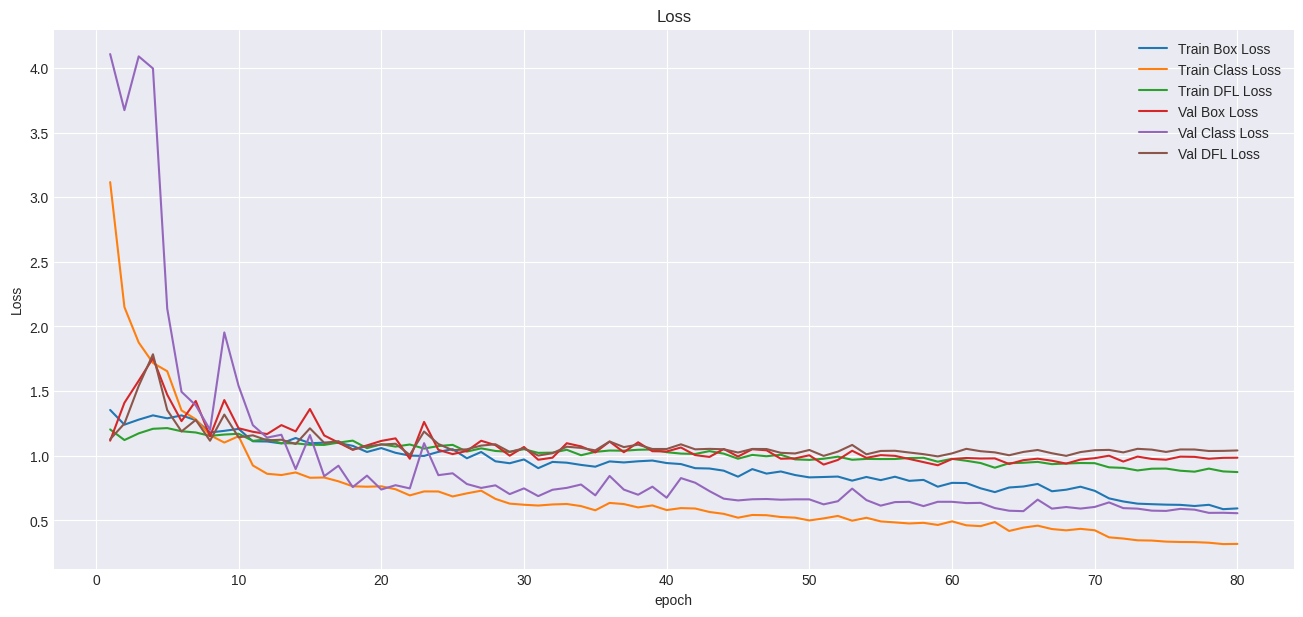

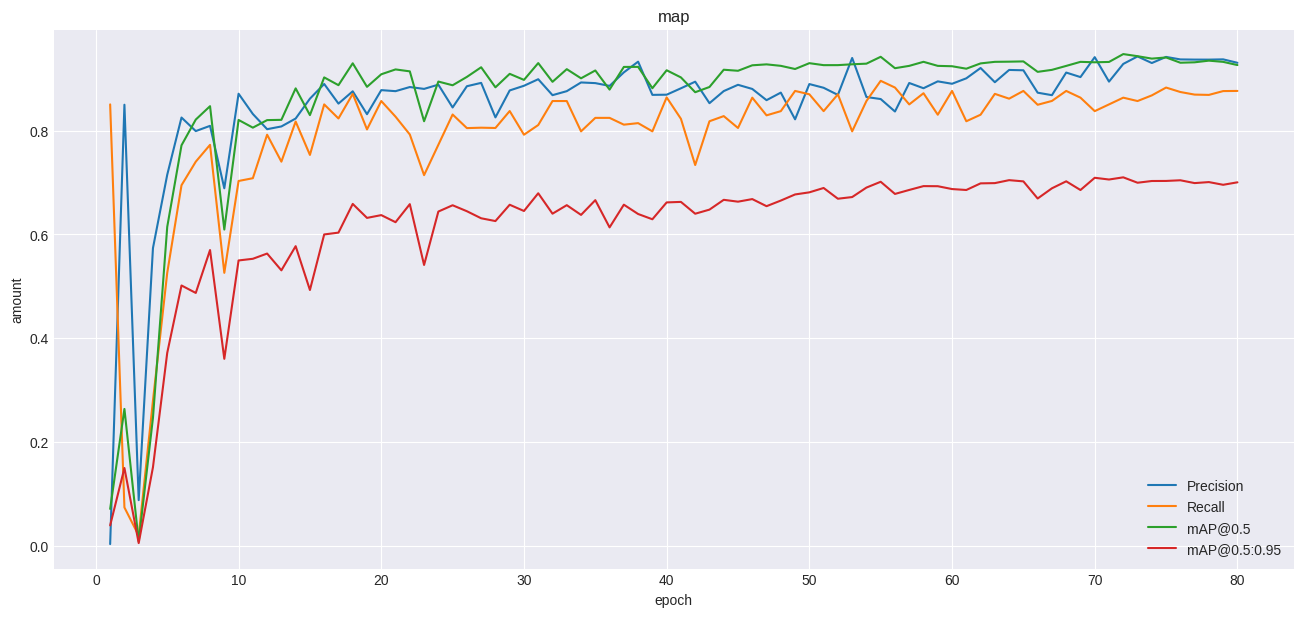


### خلاصه نتایج نهایی آموزش مدل YOLOv8

- **اپوک:** 80
- **Train Box Loss:** 0.5929
- **Train Class Loss:** 0.3184
- **Train DFL Loss:** 0.8739
- **Validation Box Loss:** 0.9849
- **Validation Class Loss:** 0.5558
- **Validation DFL Loss:** 1.0412
- **Precision:** 0.9308
- **Recall:** 0.8766
- **mAP@0.5:** 0.9265
- **mAP@0.5:0.95:** 0.7005


In [32]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

results_dir = "brain_tumor_finetune/yolov8_brain_tumor_preprocessed"
csv_path = os.path.join(results_dir, "results.csv")

df = pd.read_csv(csv_path)
print("نمایش چند سطر اول فایل results.csv:")
display(df.head())


print("\nستون‌های موجود در فایل:")
print(df.columns.tolist())

epochs = df['epoch'] if 'epoch' in df.columns else range(1, len(df)+1)

plt.figure(figsize=(16,7))
plt.plot(epochs, df['train/box_loss'], label='Train Box Loss')
plt.plot(epochs, df['train/cls_loss'], label='Train Class Loss')
plt.plot(epochs, df['train/dfl_loss'], label='Train DFL Loss')
plt.plot(epochs, df['val/box_loss'], label='Val Box Loss')
plt.plot(epochs, df['val/cls_loss'], label='Val Class Loss')
plt.plot(epochs, df['val/dfl_loss'], label='Val DFL Loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(16,7))
plt.plot(epochs, df['metrics/precision(B)'], label='Precision')
plt.plot(epochs, df['metrics/recall(B)'], label='Recall')
plt.plot(epochs, df['metrics/mAP50(B)'], label='mAP@0.5')
plt.plot(epochs, df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
plt.title('map')
plt.xlabel('epoch')
plt.ylabel('amount')
plt.legend()
plt.grid(True)
plt.show()

last_epoch = df.iloc[-1]

summary_md = f"""
### خلاصه نتایج نهایی آموزش مدل YOLOv8

- **اپوک:** {int(last_epoch['epoch'])}
- **Train Box Loss:** {last_epoch['train/box_loss']:.4f}
- **Train Class Loss:** {last_epoch['train/cls_loss']:.4f}
- **Train DFL Loss:** {last_epoch['train/dfl_loss']:.4f}
- **Validation Box Loss:** {last_epoch['val/box_loss']:.4f}
- **Validation Class Loss:** {last_epoch['val/cls_loss']:.4f}
- **Validation DFL Loss:** {last_epoch['val/dfl_loss']:.4f}
- **Precision:** {last_epoch['metrics/precision(B)']:.4f}
- **Recall:** {last_epoch['metrics/recall(B)']:.4f}
- **mAP@0.5:** {last_epoch['metrics/mAP50(B)']:.4f}
- **mAP@0.5:0.95:** {last_epoch['metrics/mAP50-95(B)']:.4f}
"""

display(Markdown(summary_md))

### ارزیابی مدل روی داده‌های تست

### مدل بارگذاری شد: `/content/brain_tumor_finetune/yolov8_brain_tumor_preprocessed/weights/best.pt`

Ultralytics 8.3.141 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 213.5±82.8 MB/s, size: 4.1 KB)


val: Scanning /content/valid/labels.cache... 223 images, 0 backgrounds, 81 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]

val: /content/valid/images/val_1 (1).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (100).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (102).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (104).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (105).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (106).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (107).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset clas


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


                   all        142        154      0.928      0.864      0.948       0.71
Speed: 0.3ms preprocess, 23.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val7


### نتایج ارزیابی مدل روی داده‌های تست:

میانگین Precision: 0.9285
میانگین Recall: 0.8636
میانگین mAP@0.5: 0.9485
میانگین mAP@0.5:0.95: 0.7101
کلاس 0:
  Precision: 0.928
  Recall: 0.864
  AP@0.5: 0.948
  AP@0.5:0.95: 0.710



<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1705 (\N{ARABIC LETTER KEHEH}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Matplotlib currently does not support Arabic natively.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1604 (\N{ARABIC LETTER LAM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1575 (\N{ARABIC LETTER ALEF}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1587 (\N{ARABIC LETTER SEEN}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1605 (\N{ARABIC LETTER MEEM}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-input-29-f4e3b316c2d3>:46: UserWarning: Glyph 1602 (\N{ARABIC LETTER QAF}) missing from font(s) Liberation Sans.
  plt.tight_layout()
<ipython-inp

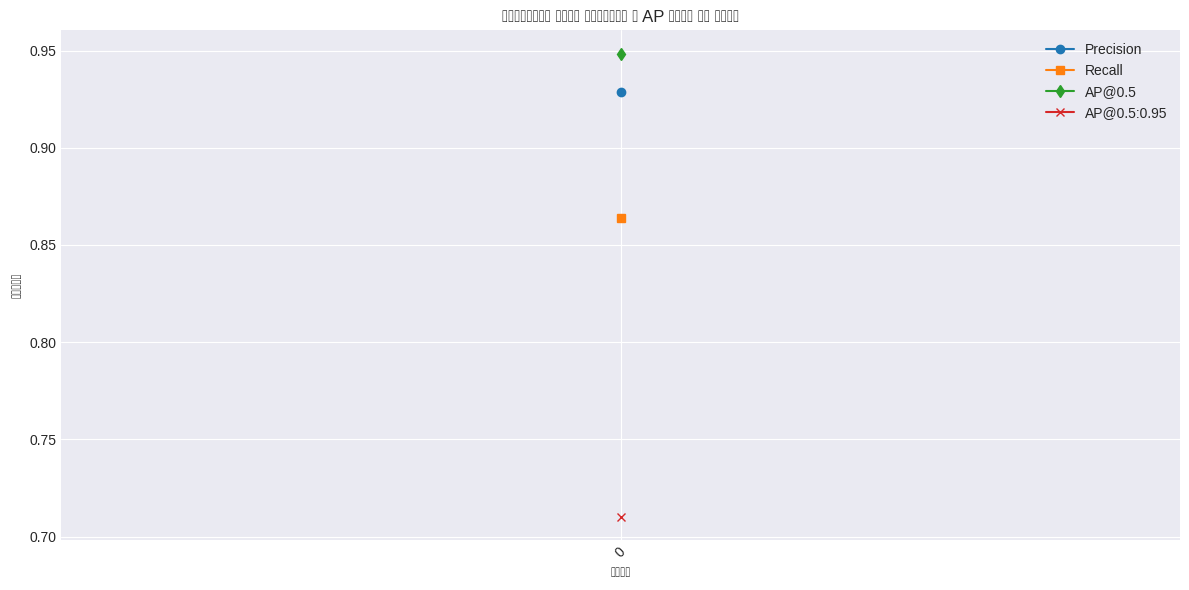


image 1/1 /content/valid/images/val_1 (176).jpg: 640x640 1 tumor, 80.1ms
Speed: 3.5ms preprocess, 80.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1662 (\N{ARABIC LETTER PEH}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1588 (\N{ARABIC LETTER SHEEN}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8204 (\N{ZERO WIDTH NON-JOINER}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1606 (\N{ARABIC LETTER NOON}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 1589 (\N{ARABIC LETTER SAD}) missing from font(s) Liberation Sans.
  fig.canvas.print_figure(bytes_io,

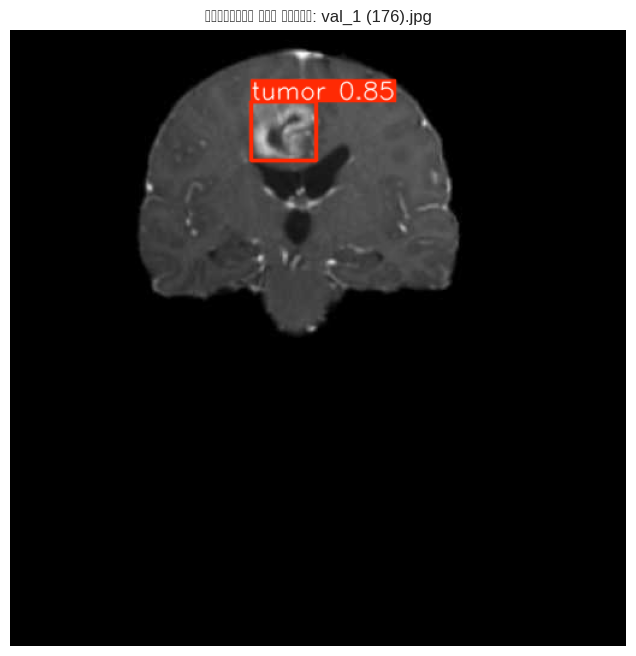


image 1/1 /content/valid/images/val_1 (181).jpg: 640x640 1 tumor, 50.3ms
Speed: 3.4ms preprocess, 50.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


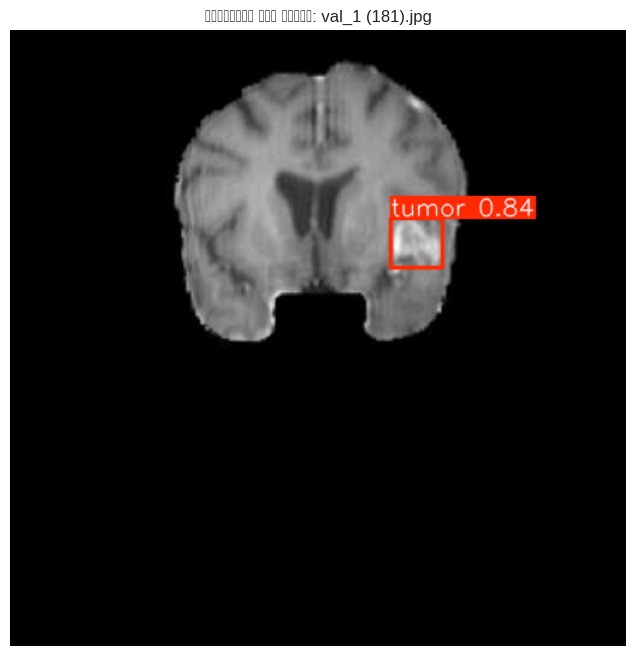


image 1/1 /content/valid/images/val_1 (118).jpg: 640x640 1 tumor, 49.1ms
Speed: 3.1ms preprocess, 49.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


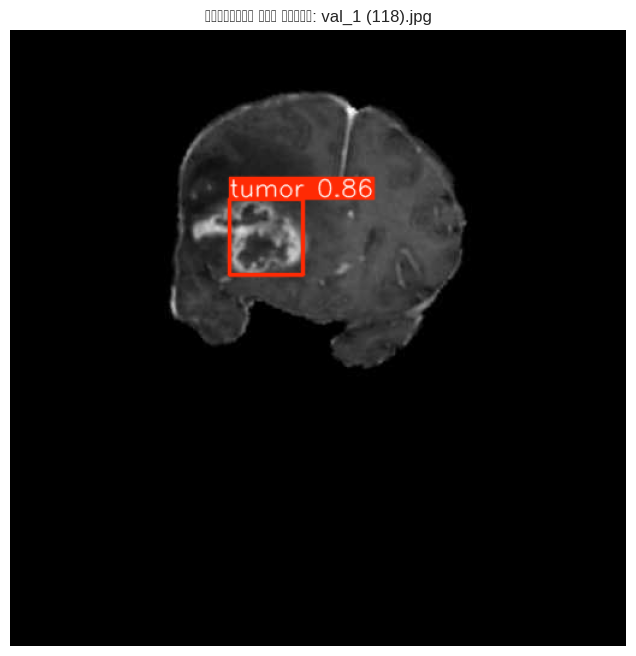


image 1/1 /content/valid/images/val_1 (7).jpg: 640x640 1 tumor, 46.9ms
Speed: 3.1ms preprocess, 46.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


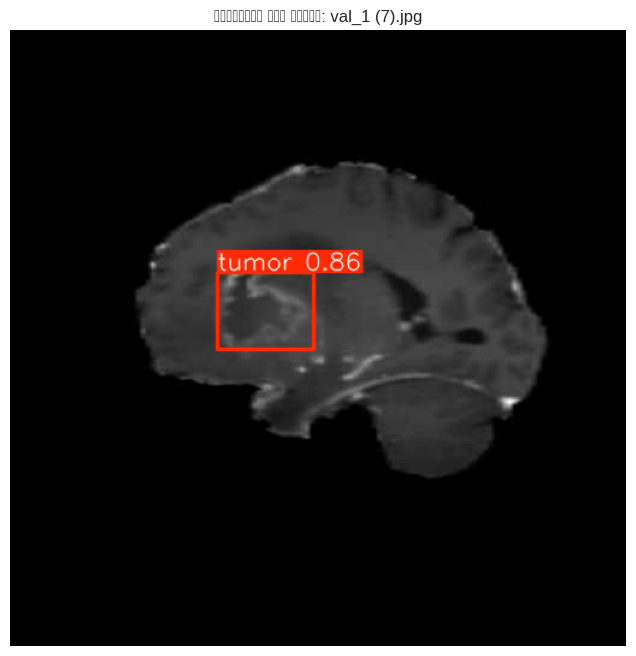


image 1/1 /content/valid/images/val_1 (53).jpg: 640x640 1 tumor, 46.7ms
Speed: 2.5ms preprocess, 46.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


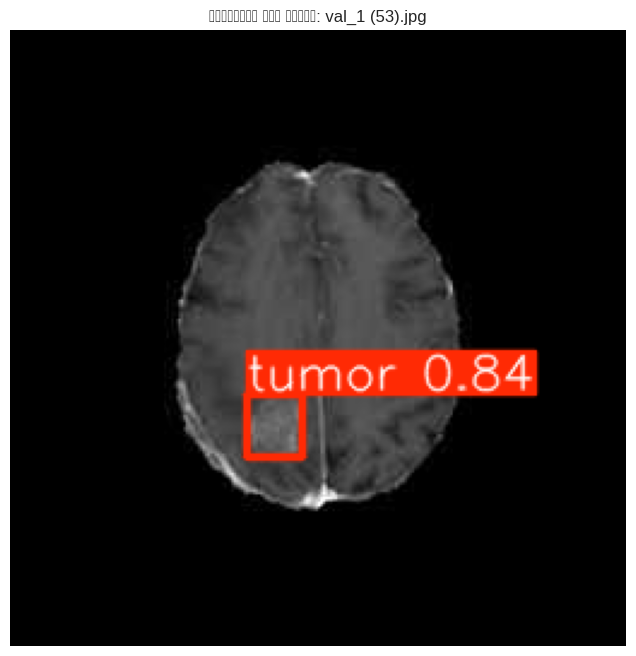

In [ ]:
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, Markdown


model_path = "/content/brain_tumor_finetune/yolov8_brain_tumor_preprocessed/weights/best.pt"
model = YOLO(model_path)
display(Markdown(f"### مدل بارگذاری شد: `{model_path}`"))

yaml_path = "/content/brain_tumor.yaml"


results = model.val(data=yaml_path, split='test')
display(Markdown("### نتایج ارزیابی مدل روی داده‌های تست:"))

print(f"میانگین Precision: {results.box.mp:.4f}")
print(f"میانگین Recall: {results.box.mr:.4f}")
print(f"میانگین mAP@0.5: {results.box.map50:.4f}")
print(f"میانگین mAP@0.5:0.95: {results.box.map:.4f}")


for i, cls_name in enumerate(results.names):
    print(f"کلاس {cls_name}:")
    print(f"  Precision: {results.box.p[i]:.3f}")
    print(f"  Recall: {results.box.r[i]:.3f}")
    print(f"  AP@0.5: {results.box.ap50[i]:.3f}")
    print(f"  AP@0.5:0.95: {results.box.ap[i]:.3f}")
    print("")

classes = list(results.names)
x = range(len(classes))

plt.figure(figsize=(12,6))
plt.plot(x, results.box.p, 'o-', label='Precision')
plt.plot(x, results.box.r, 's-', label='Recall')
plt.plot(x, results.box.ap50, 'd-', label='AP@0.5')
plt.plot(x, results.box.ap, 'x-', label='AP@0.5:0.95')
plt.xticks(x, classes, rotation=45)
plt.title("معیارهای دقت، یادآوری و AP برای هر کلاس")
plt.xlabel("کلاس")
plt.ylabel("مقدار")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


test_img_dir = "/content/valid/images"
test_imgs = os.listdir(test_img_dir)[:5]

for img_name in test_imgs:
    img_path = os.path.join(test_img_dir, img_name)
    preds = model.predict(source=img_path, imgsz=640, conf=0.25)
    annotated_img = preds[0].plot()
    plt.figure(figsize=(8,8))
    plt.imshow(annotated_img)
    plt.title(f"پیش‌بینی روی تصویر: {img_name}")
    plt.axis('off')
    plt.show()


###نمایش دقت

In [ ]:
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Precision: 0.9285
Recall: 0.8636
mAP50: 0.9485
mAP50-95: 0.7101


###  رسم نمودارها

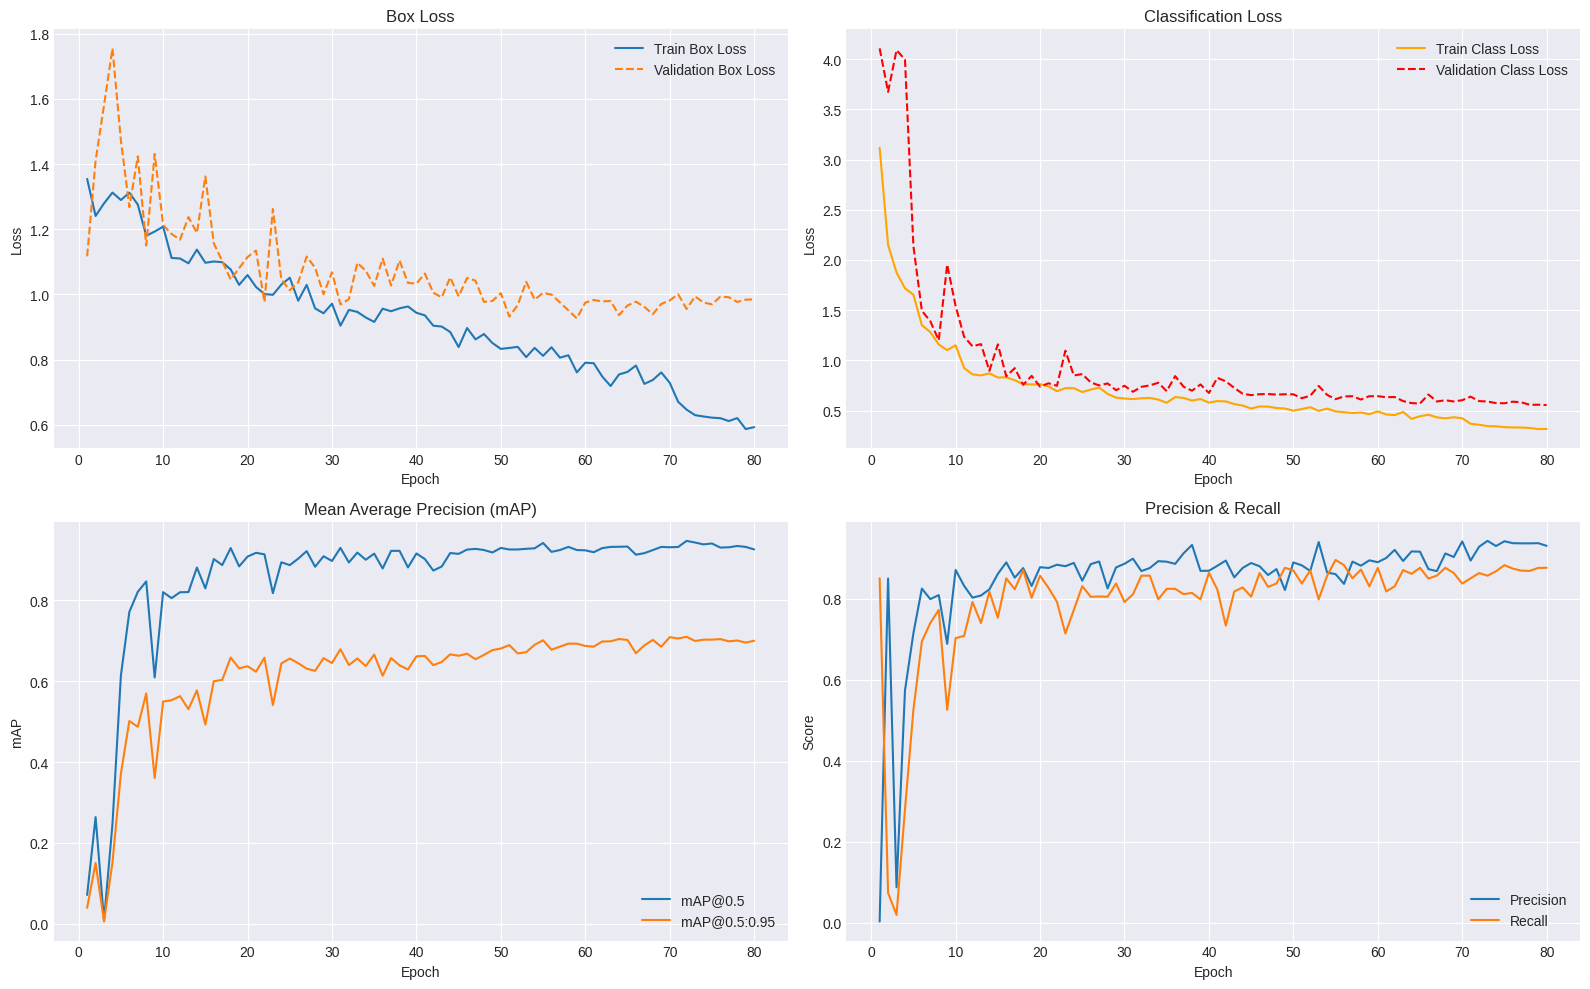

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/content/brain_tumor_finetune/yolov8_brain_tumor_preprocessed/results.csv"
df = pd.read_csv(csv_path)

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(16, 10))

# Plot 1: Box loss
plt.subplot(2, 2, 1)
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Validation Box Loss", linestyle='--')
plt.title("Box Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot 2: Classification loss
plt.subplot(2, 2, 2)
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss", color="orange")
plt.plot(df["epoch"], df["val/cls_loss"], label="Validation Class Loss", color="red", linestyle='--')
plt.title("Classification Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot 3: mAP
plt.subplot(2, 2, 3)
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.title("Mean Average Precision (mAP)")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.legend()

# Plot 4: Precision and Recall
plt.subplot(2, 2, 4)
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.title("Precision & Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()

plt.tight_layout()
plt.show()
